<a href="https://colab.research.google.com/github/taitip-supha/DeepLearn-Keras/blob/main/04_AutoEncoder/AVE_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Prepar the Enviroment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-1a3ec32e-ef6c-cf18-aaff-12528e53c6d4)


In [ ]:
#Import package
import sys,os,time,datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
#Set Disable eager execution
from tensorflow.python.framework.ops import disable_eager_execution
# Since TF 2.x, eager mode is enabled by default
print( f"Before : TF executing eagerly : {tf.executing_eagerly()}")
if tf.executing_eagerly():
   disable_eager_execution()

print( f"After : TF executing eagerly : {tf.executing_eagerly()}")

Before : TF executing eagerly : True
After : TF executing eagerly : False


In [ ]:
#Set fixed seeding values for reproducability during experiments
#to guarantee reproducability, make sure valuesfor any randomize poperation are all set
np.random.seed(1234)
tf.random.set_seed(5678)

# 1 Prepare CelebA dataset

##>> 1.1 Load CelebA 64x64 

In [ ]:
import os
import gdown
from zipfile import ZipFile

os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
if 1501%500 ==0:
  print('a')

In [ ]:
%%time
load_n = 202599
load_img = []
for i,img_file in enumerate(os.listdir(f"./celeba_gan/img_align_celeba")[:load_n]):
   if i%500 ==0:
     print(f" Current read image {i}/{load_n}")
   try :
     img = tf.keras.preprocessing.image.load_img(f"./celeba_gan/img_align_celeba/{img_file}", target_size=(64,64,3))
     img = tf.keras.preprocessing.image.img_to_array(img)
     load_img.append(img)
   except :
     print(img_file)
load_img = np.array(load_img)
print(f" shape of data : {load_img.shape}")

 Current read image 0/20000
 Current read image 500/20000
 Current read image 1000/20000
 Current read image 1500/20000
 Current read image 2000/20000
 Current read image 2500/20000
 Current read image 3000/20000
 Current read image 3500/20000
 Current read image 4000/20000
 Current read image 4500/20000
 Current read image 5000/20000
 Current read image 5500/20000
 Current read image 6000/20000
 Current read image 6500/20000
 Current read image 7000/20000
 Current read image 7500/20000
 Current read image 8000/20000
 Current read image 8500/20000
 Current read image 9000/20000
 Current read image 9500/20000
 Current read image 10000/20000
 Current read image 10500/20000
 Current read image 11000/20000
 Current read image 11500/20000
 Current read image 12000/20000
 Current read image 12500/20000
 Current read image 13000/20000
 Current read image 13500/20000
 Current read image 14000/20000
 Current read image 14500/20000
 Current read image 15000/20000
 Current read image 15500/20000


In [ ]:
path = f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/caleba_64x64_{load_n}.npy"
np.save(path,load_img)

##>> 1.2 Split Data for Train and Test

In [ ]:
#load data
load_n = 202599
load_img = np.load(f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/caleba_64x64_{load_n}.npy" )

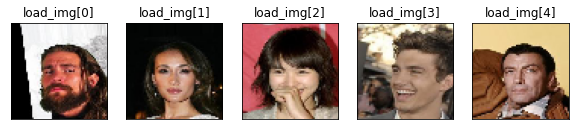

In [ ]:
#Plot the first five image for check data
np.random.shuffle(load_img)
plt.figure(figsize=(10,10))
for i in range(5):
   plt.subplot(150+1+i).set_title(f"load_img[{i}]")
   plt.imshow( load_img[i].astype(np.uint8))
   plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [ ]:
test_ratio = 0.2
np.random.shuffle(load_img)
x_train , x_test = load_img[:int(len(load_img)*(1-test_ratio))] , load_img[int(len(load_img)*(1-test_ratio)):]
print( f"x_train_nasnet shape={x_train.shape}, dtype={x_train.dtype}, min={np.min(x_train):.4f} ,max={np.max(x_train):.4f}")
print( f"x_test_nasnet shape={x_test.shape}, dtype={x_test.dtype}, min={np.min(x_test):.4f} ,max={np.max(x_test):.4f}")

x_train_nasnet shape=(162079, 64, 64, 3), dtype=float32, min=0.0000 ,max=255.0000
x_test_nasnet shape=(40520, 64, 64, 3), dtype=float32, min=0.0000 ,max=255.0000


##>> 1.3 Prepare data for Training

In [ ]:
#Covert each pixel from unsigned int 8-bit (0-255) data type to 32-bit floating point data type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [ ]:
# Input normalization from 0-255 to 0.0 - 1.0
x_train /= 255
x_test /= 255

In [ ]:
# Check Shape is (batch_size, H, W, Channel)
print( f"x_train_nasnet shape={x_train.shape}, dtype={x_train.dtype}, min={np.min(x_train):.4f} ,max={np.max(x_train):.4f}")
print( f"x_test_nasnet shape={x_test.shape}, dtype={x_test.dtype}, min={np.min(x_test):.4f} ,max={np.max(x_test):.4f}")

x_train_nasnet shape=(162079, 64, 64, 3), dtype=float32, min=0.0000 ,max=1.0000
x_test_nasnet shape=(40520, 64, 64, 3), dtype=float32, min=0.0000 ,max=1.0000


# 2 Create the network architecture

### >> Create Sampling Layer

In [ ]:
class Sampling( tf.keras.layers.Layer ):
  """
  code from https://keras.io/examples/generative/vae/
  Reparameterization trick by sampling from an isotropic unit Gaussian.
  Instead of sampling from Q(z|X), we sample from epsilon = N(0,I).
  z = z_mean + sqrt(var) * epsilon, when z is an encoded latent vector
  """
  def call(self, inputs ):
    z_mean, z_logvar = inputs
    batch_size = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal( shape=(batch_size,dim) )
    return z_mean+tf.exp(0.5 * z_logvar)*epsilon

### >> Encoder

In [ ]:
latent_dim=1000

in_img = tf.keras.layers.Input( shape=(64, 64, 3), name='input_img')
x = tf.keras.layers.Dropout(0.2, name='encoder_Dropout')(in_img)

#Encoder
x = tf.keras.layers.Conv2D( 32, (3,3), activation='relu', padding='same', strides=2 ,name='encoder_CNN01')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1, name='encoder_batchnorm01')(x)

x = tf.keras.layers.Conv2D( 64, (3,3), activation='relu', padding='same', strides=2 ,name='encoder_CNN02')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1, name='encoder_batchnorm02')(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2 ,name='encoder_CNN03')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1, name='encoder_batchnorm03')(x)

x = tf.keras.layers.Flatten(name='encoder_flatten')(x)

#### Bottlenneck ####
z_mean = tf.keras.layers.Dense( latent_dim, name='z_mean')(x)
z_logvar = tf.keras.layers.Dense( latent_dim, name='z_logvar')(x)

# Use reparameterization trick to push the simpling 
z = Sampling(name='z_sampling')([z_mean,z_logvar])

#Instantiate the encoder model
encoder = tf.keras.models.Model( in_img, [z_mean, z_logvar, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_Dropout (Dropout)      (None, 64, 64, 3)    0           ['input_img[0][0]']              
                                                                                                  
 encoder_CNN01 (Conv2D)         (None, 32, 32, 32)   896         ['encoder_Dropout[0][0]']        
                                                                                                  
 encoder_CNN02 (Conv2D)         (None, 16, 16, 64)   18496       ['encoder_CNN01[0][0]']          
                                                                                            

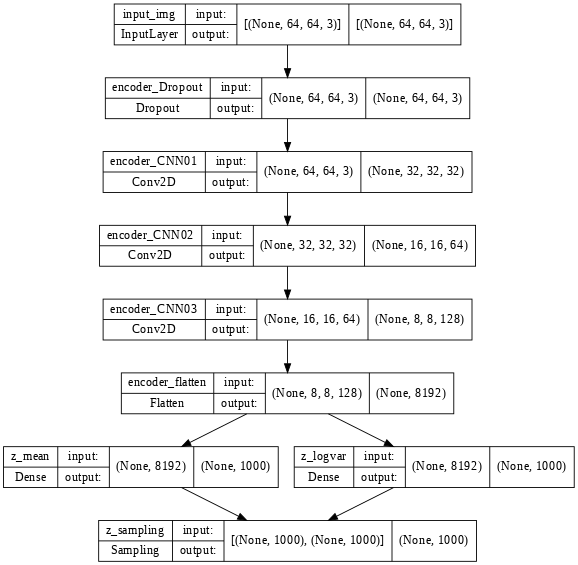

In [ ]:
tf.keras.utils.plot_model(encoder, "VAE_Encoder.png", show_shapes=True, show_layer_names=True ,dpi=64)

###>> Decoder

In [ ]:
#### Decoder ####
latent_inputs = tf.keras.layers.Input( shape=(latent_dim,), name='latent_sampling') #Output : (None, 2)

x = tf.keras.layers.Dense( 8*8*128 ,activation='relu', name='decoder_dense')(latent_inputs)  
x = tf.keras.layers.Reshape( (8,8,128), name='decoder_rehape' )(x)

x = tf.keras.layers.Conv2DTranspose( 128, (3,3), activation='relu', padding='same', strides=2, name='decoder_CNN0T1')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1, name='decoder_batchnorm01')(x)
x = tf.keras.layers.Conv2DTranspose( 64, (3,3), activation='relu', padding='same', strides=2, name='decoder_CNN0T2')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1, name='decoder_batchnorm02')(x)
x = tf.keras.layers.Conv2DTranspose( 32, (3,3), activation='relu', padding='same', strides=2, name='decoder_CNN0T3')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1, name='decoder_batchnorm03')(x)


#output
out_img = tf.keras.layers.Conv2DTranspose( 3, (3,3), activation='sigmoid', padding='same', name='output_img')(x)

# Instantiate the decoder model
decoder = tf.keras.models.Model( latent_inputs, out_img, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_sampling (InputLayer  [(None, 1000)]           0         
 )                                                               
                                                                 
 decoder_dense (Dense)       (None, 8192)              8200192   
                                                                 
 decoder_rehape (Reshape)    (None, 8, 8, 128)         0         
                                                                 
 decoder_CNN0T1 (Conv2DTrans  (None, 16, 16, 128)      147584    
 pose)                                                           
                                                                 
 decoder_CNN0T2 (Conv2DTrans  (None, 32, 32, 64)       73792     
 pose)                                                           
                                                           

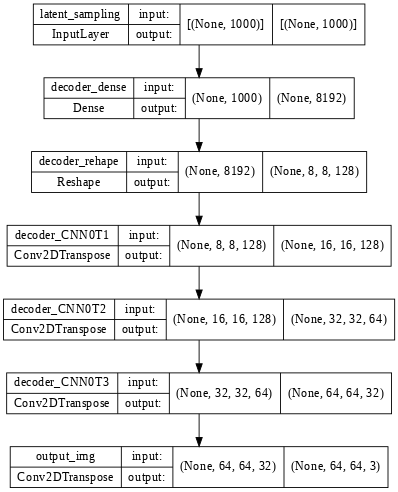

In [ ]:
tf.keras.utils.plot_model(decoder, "VAE_Decoder.png", show_shapes=True, show_layer_names=True ,dpi=64)

###>> Construct VAE Model

In [ ]:
# Amoung the thee output of encoder, send only the last one (=z) to decoder
vae_out = decoder( encoder(in_img)[2] )

#Instantiate AVE model
vae = tf.keras.models.Model( in_img, vae_out, name='vae_cnn_model' )
vae.summary()

Model: "vae_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 1000),            16479248  
                              (None, 1000),                      
                              (None, 1000)]                      
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         8440899   
                                                                 
Total params: 24,920,147
Trainable params: 24,920,147
Non-trainable params: 0
_________________________________________________________________


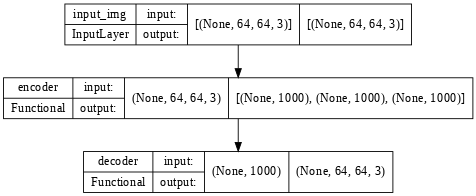

In [ ]:
tf.keras.utils.plot_model(vae, "VAE_CNN_model.png", show_shapes=True, show_layer_names=True ,dpi=64)

# 3 Compile and Train the model

### >> Compile the model

In [ ]:
def vae_loss( y_true, y_pred ):
   #Original reconstruction loss choose one from two lines below
   recon_loss = tf.keras.backend.square( y_pred-y_true )
   recon_loss =  tf.keras.backend.mean(recon_loss, axis=None)
   recon_loss = tf.keras.backend.sqrt(recon_loss)
   #recon_loss = tf.keras.losses.binary_crossentropy( y_true, y_pred)
   # Extract two output vectors from the 'encoder'
   z_mean = vae.get_layer('encoder').get_layer('z_mean').output
   z_logvar = vae.get_layer('encoder').get_layer('z_logvar').output

   # latent loss
   latent_loss = 1 + z_logvar - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_logvar)
   latent_loss = tf.keras.backend.sum( latent_loss, axis=None ) 
   latent_loss *= -0.5

   return tf.keras.backend.mean( (recon_loss * 999 *100) + latent_loss )

In [ ]:
vae.compile( optimizer='rmsprop', loss=vae_loss, metrics=["acc"] )

### >> Create a custom callback

In [ ]:
my_history = dict()
class GenerativeModel_Eval( tf.keras.callbacks.Callback ):
  def __init__(self ,epochs, n=5) :
     """ 
     Arguments:
       epochs(int) : how many epochs to train the model
       n (int) : evaluate the model once for every 'n' epoch passed
     """
     super(GenerativeModel_Eval, self).__init__()
     self.__epochs = epochs
     self.__n = n if n>0 else 5

  def on_epoch_begin( self, epoch, logs=None):
     if epoch % self.__n == 0:
       self.__predict_with_current_model( epoch )

  def on_train_end( self, logs=None):
     for k,v in self.model.history.history.items():
       my_history[k] = v.copy()
     self.__predict_with_current_model( self.__epochs)
  
  def __predict_with_current_model(self, current_epoch, n_samples=6):
     """ 
     Argument:
       current_epoch (int) : the number of current epoch
       n_sample (int) : evaluate the first 'n_sample' samples in the test set """
    
     #Use the current model to predict x_test[0] - x_test[n-cols-1]
     n_cols = n_samples
     n_rows = 2

     #Prepare 2-row of image (each row contains n_cols images)
     fig_h =5
     fig, axes = plt.subplots( n_rows, n_cols, figsize=( (fig_h * n_cols) // n_rows, fig_h) )
     fig.suptitle( f"******** Model after being train for {current_epoch} epochs" )
     for i in range(n_cols):
        x_recon = (self.model.predict( np.array( [x_test[i] ] ) )*255).astype(np.uint8)

        # First row is original x_test image
        axes[0, i].set_title( f" x_test[{i}]" )
        
        axes[0, i].imshow( (x_test[i]*255).astype(np.uint8) )

        # Second row is the reconstructed image by auto encoder
        axes[1, i].imshow( x_recon.reshape(64,64,3) )

     plt.show()


###>> Train the model

Train on 162079 samples, validate on 40520 samples


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


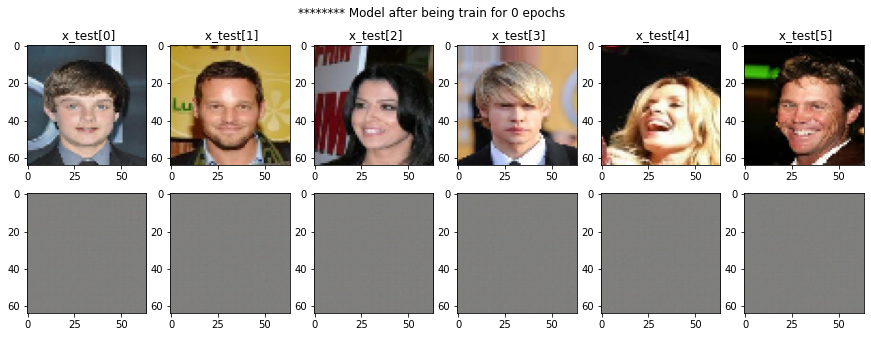

Epoch 1/20
162079/162079 [==============================] - ETA: 0s - loss: 18158.4676 - acc: 0.7502

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


162079/162079 [==============================] - 104s 640us/sample - loss: 18158.4676 - acc: 0.7502 - val_loss: 16681.3725 - val_acc: 0.7572
Epoch 2/20
162079/162079 [==============================] - 102s 629us/sample - loss: 16242.7651 - acc: 0.7704 - val_loss: 15781.4769 - val_acc: 0.7697
Epoch 3/20
162079/162079 [==============================] - 102s 627us/sample - loss: 15298.8969 - acc: 0.7799 - val_loss: 15349.6287 - val_acc: 0.7785
Epoch 4/20
162079/162079 [==============================] - 102s 628us/sample - loss: 14891.0437 - acc: 0.7838 - val_loss: 15071.3208 - val_acc: 0.7476
Epoch 5/20
162079/162079 [==============================] - 101s 626us/sample - loss: 14685.2063 - acc: 0.7857 - val_loss: 14943.7614 - val_acc: 0.7780


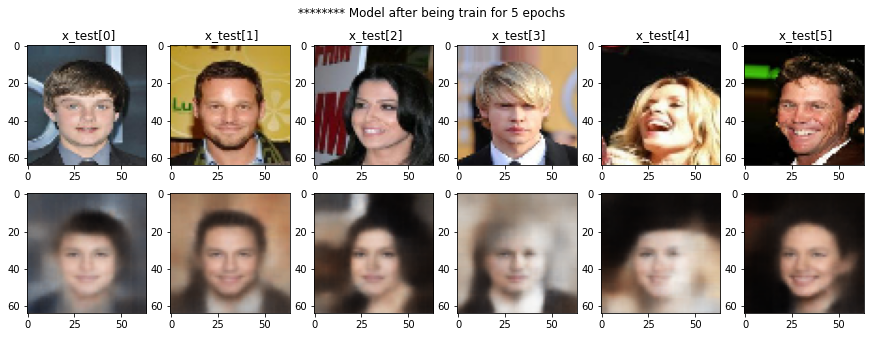

Epoch 6/20
162079/162079 [==============================] - 101s 626us/sample - loss: 14543.5821 - acc: 0.7879 - val_loss: 14946.7748 - val_acc: 0.7797
Epoch 7/20
162079/162079 [==============================] - 102s 627us/sample - loss: 14449.6343 - acc: 0.7889 - val_loss: 15054.6941 - val_acc: 0.7796
Epoch 8/20
162079/162079 [==============================] - 102s 627us/sample - loss: 14382.2551 - acc: 0.7891 - val_loss: 14577.6811 - val_acc: 0.7890
Epoch 9/20
162079/162079 [==============================] - 101s 626us/sample - loss: 14322.3836 - acc: 0.7895 - val_loss: 14571.0120 - val_acc: 0.7807
Epoch 10/20
162079/162079 [==============================] - 101s 625us/sample - loss: 14277.2739 - acc: 0.7902 - val_loss: 14625.7303 - val_acc: 0.7815


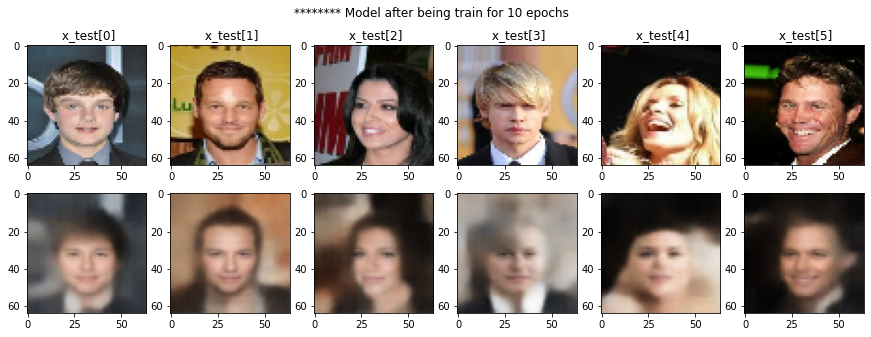

Epoch 11/20
162079/162079 [==============================] - 101s 625us/sample - loss: 14241.9626 - acc: 0.7906 - val_loss: 14696.9555 - val_acc: 0.7793
Epoch 12/20
162079/162079 [==============================] - 102s 627us/sample - loss: 14214.5206 - acc: 0.7913 - val_loss: 15173.1739 - val_acc: 0.7620
Epoch 13/20
162079/162079 [==============================] - 102s 628us/sample - loss: 14191.6095 - acc: 0.7908 - val_loss: 14743.7731 - val_acc: 0.7770
Epoch 14/20
162079/162079 [==============================] - 102s 626us/sample - loss: 14170.7574 - acc: 0.7913 - val_loss: 14581.6758 - val_acc: 0.7675
Epoch 15/20
162079/162079 [==============================] - 101s 624us/sample - loss: 14152.3794 - acc: 0.7913 - val_loss: 15228.7907 - val_acc: 0.7709


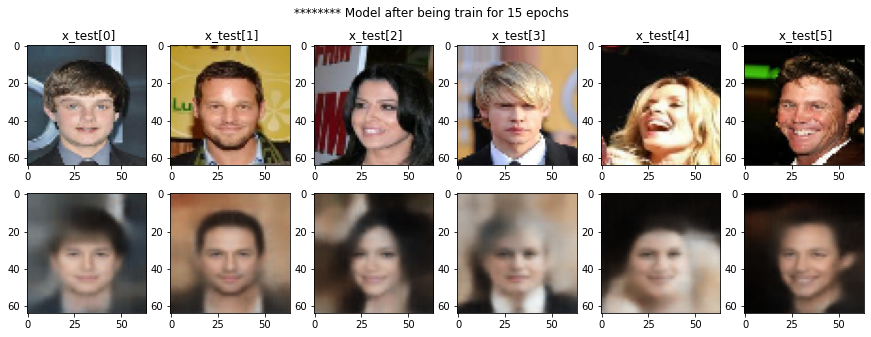

Epoch 16/20
162079/162079 [==============================] - 101s 624us/sample - loss: 14136.6853 - acc: 0.7909 - val_loss: 14478.5893 - val_acc: 0.7823
Epoch 17/20
162079/162079 [==============================] - 101s 623us/sample - loss: 14122.1770 - acc: 0.7910 - val_loss: 14935.4913 - val_acc: 0.7712
Epoch 18/20
162079/162079 [==============================] - 101s 622us/sample - loss: 14108.2122 - acc: 0.7914 - val_loss: 14942.7846 - val_acc: 0.7796
Epoch 19/20
162079/162079 [==============================] - 101s 624us/sample - loss: 14096.3831 - acc: 0.7910 - val_loss: 15155.0870 - val_acc: 0.7106
Epoch 20/20
162079/162079 [==============================] - 101s 626us/sample - loss: 14086.4694 - acc: 0.7908 - val_loss: 14397.5239 - val_acc: 0.7738


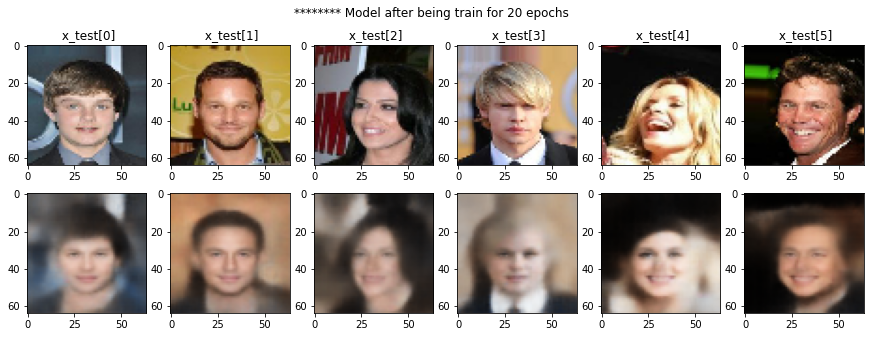

In [ ]:
n_epochs = 20
ex3_hist = vae.fit( x_train, x_train, validation_data=(x_test, x_test), 
                   batch_size=32, epochs=n_epochs, verbose=1, callbacks=[GenerativeModel_Eval(n_epochs,5) ])

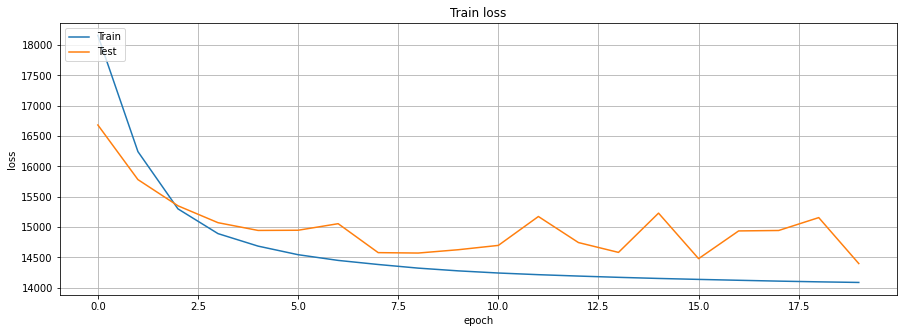

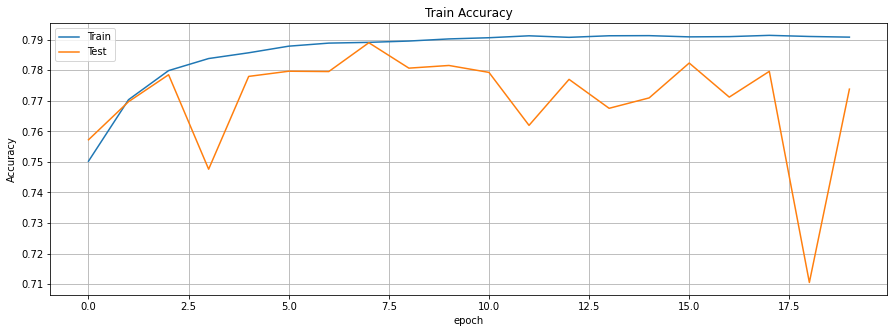

In [ ]:
# Summarize history for mean absolute error(mae)/Accuracy
if 'loss' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['loss'] )
  plt.plot( my_history['val_loss'] )
  plt.title( 'Train loss')
  plt.ylabel( 'loss')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()
if 'acc' in my_history.keys():
  plt.figure( figsize=(15,5) )
  plt.plot( my_history['acc'] )
  plt.plot( my_history['val_acc'] )
  plt.title( 'Train Accuracy')
  plt.ylabel( 'Accuracy')
  plt.xlabel('epoch')
  plt.legend( ['Train','Test'], loc='upper left')
  plt.grid()
  plt.show()

# 4 Evaluate the model on test set

In [ ]:
ex3_result = vae.evaluate( x_test, x_test, batch_size=128)
print(f"{vae.metrics_names} = {ex3_result}")

['loss', 'acc'] = [20573.05272319225, 0.7739817]


# 5 Inference

##>> Generate from picture

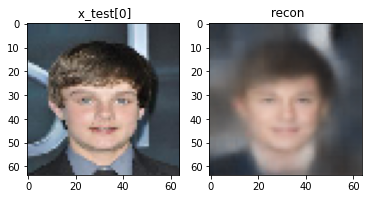

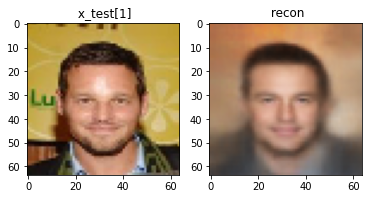

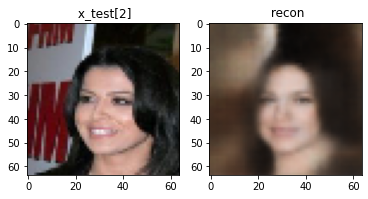

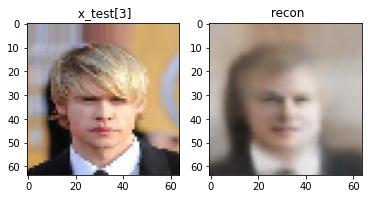

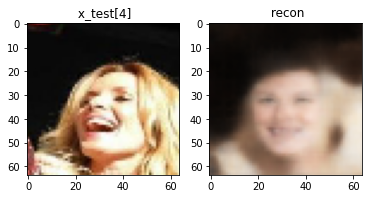

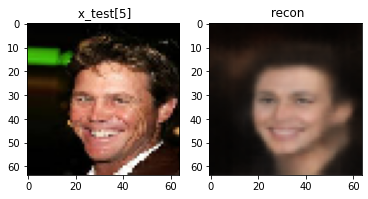

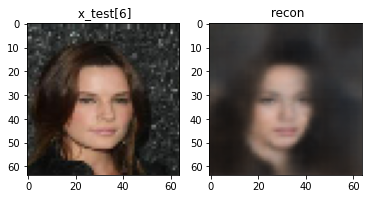

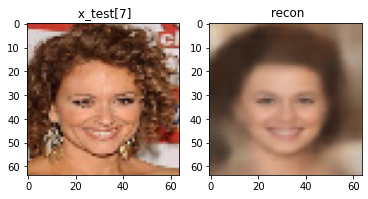

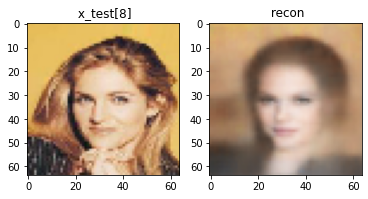

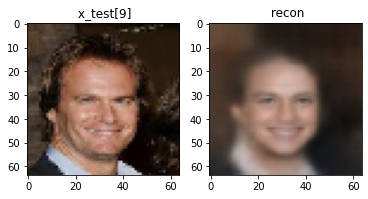

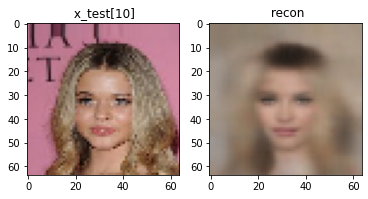

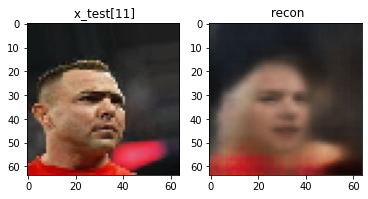

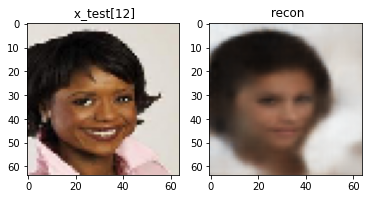

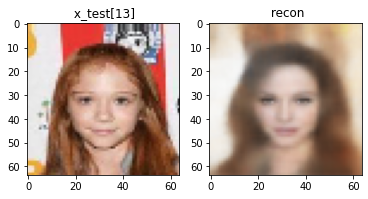

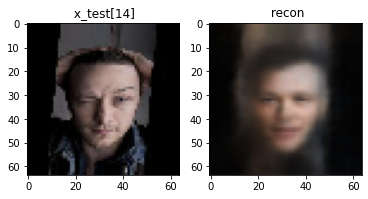

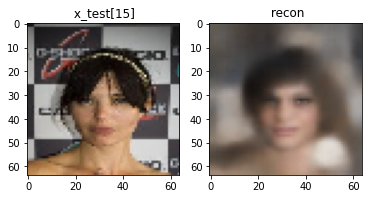

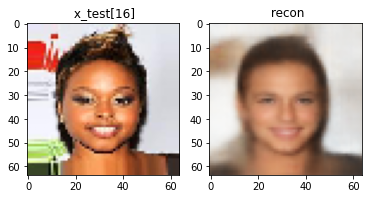

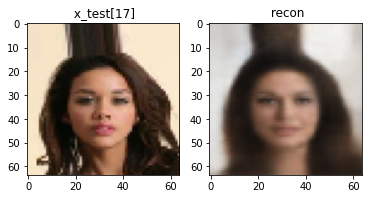

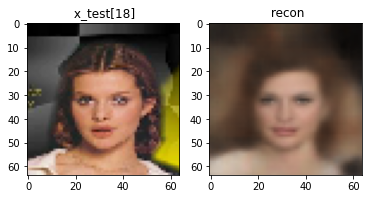

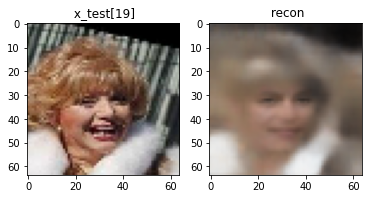

In [ ]:
n = 20
for i in range(n):
   x_recon = (vae.predict( np.array( [x_test[i] ] ) )*255).astype(np.uint8)

   # First row is original x_test image
   plt.subplot(1,2,1).set_title( f" x_test[{i}]" )
   plt.imshow( x_test[i].reshape(64,64,3))
   # Second row is the reconstructed image by auto encoder
   plt.subplot(1,2,2).set_title( f" recon" )
   plt.imshow( x_recon.reshape(64,64,3))
   plt.show()

##>> Latent Visualization 

In [ ]:
z_mean, _, _ = encoder.predict(x_train)
print(f"z_mean : {z_mean.shape}")

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


z_mean : (162079, 1000)


In [ ]:
from sklearn.decomposition import PCA
pca2dim = PCA(n_components=2).fit(z_mean)
plot2d = pca2dim.transform(z_mean)
print(f" plot2d[0] : min {min(plot2d[0])}/max {max(plot2d[0])} ")
print(f" plot2d[1] : min {min(plot2d[1])}/max {max(plot2d[1])} ")

 plot2d[0] : min -2.669732093811035/max -0.18760284781455994 
 plot2d[1] : min 0.6722046136856079/max 0.7039786577224731 


# 6 Generate New Image from random values

In [ ]:
val01 = np.linspace( min(plot2d[0]), max(plot2d[0]), 4)
val02 = np.linspace( min(plot2d[1]), max(plot2d[1]), 4)

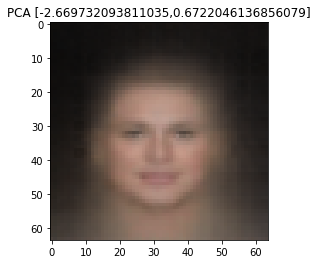

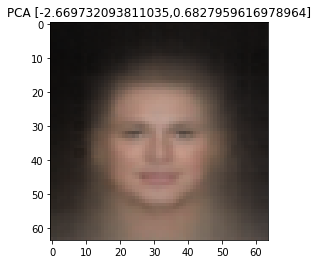

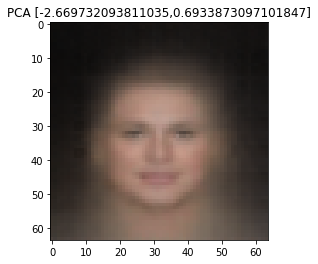

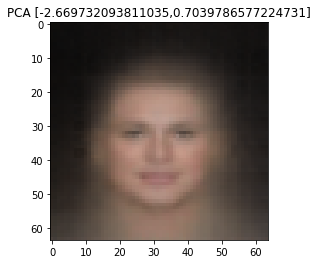

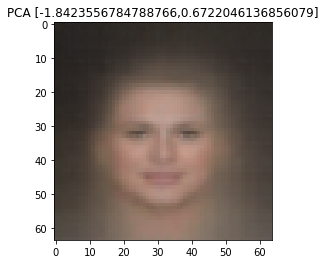

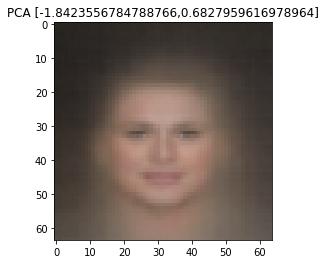

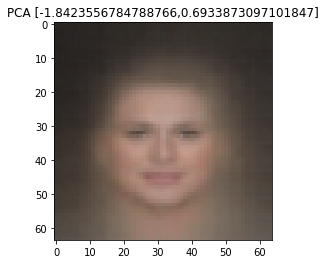

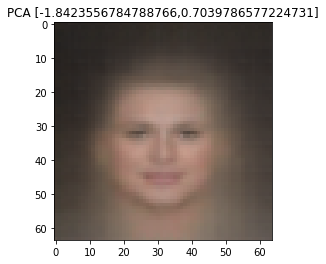

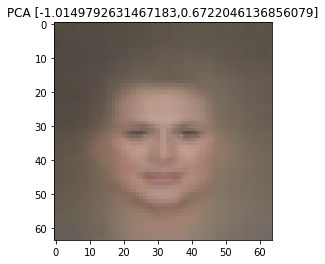

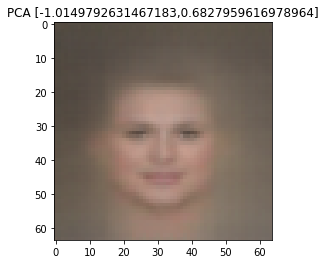

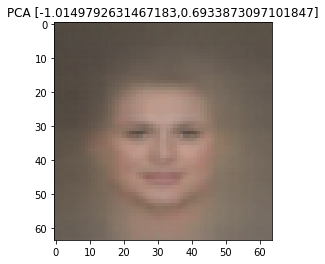

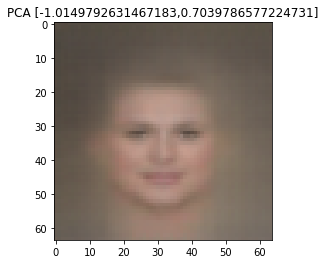

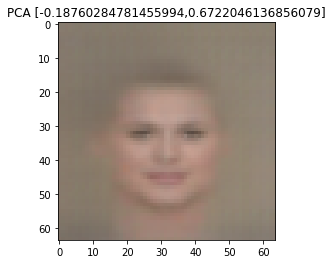

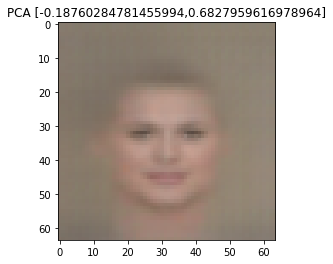

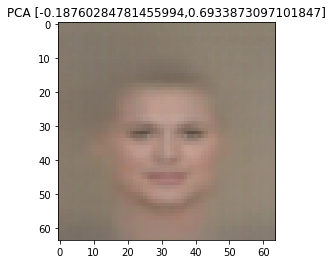

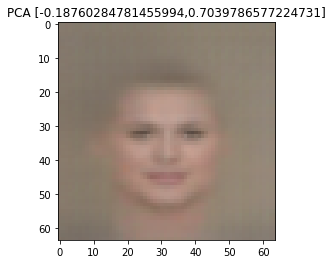

In [ ]:
for val_i in val01:
  for val_j in val02:
    z_simple = pca2dim.inverse_transform([val_i,val_j]).reshape(1,1000)
    gen_img = (decoder.predict(z_simple)[0]*255).astype(np.uint8)
    plt.imshow( gen_img )
    plt.title(f'PCA [{val_i},{val_j}]')
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

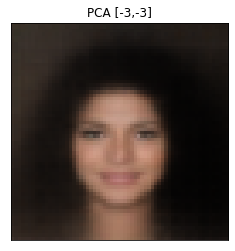

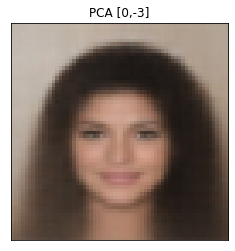

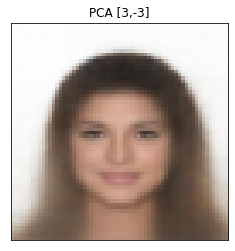

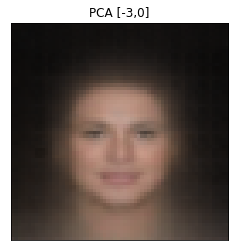

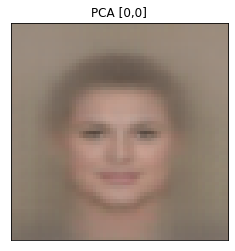

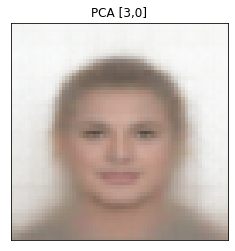

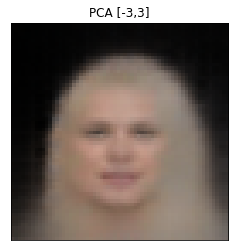

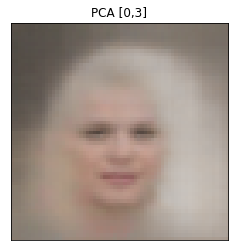

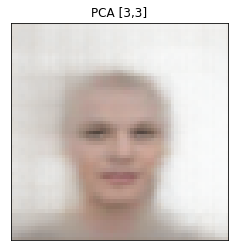

In [ ]:
lst_generate = [ [-3,-3],[0,-3],[3,-3],[-3,0],[0,0],[3,0],[-3,3],[0,3],[3,3]]
for gen in lst_generate:
   z_simple = pca2dim.inverse_transform([gen[0],gen[1]]).reshape(1,1000)
   gen_img = (decoder.predict(z_simple)[0]*255).astype(np.uint8)
   plt.imshow( gen_img )
   plt.title(f'PCA [{gen[0]},{gen[1]}]')
   plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
   plt.show()

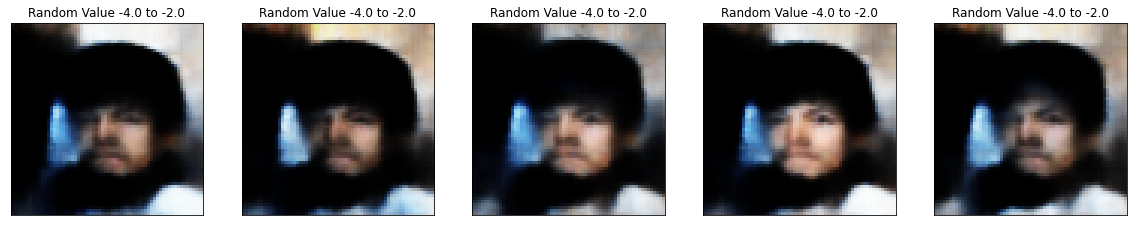

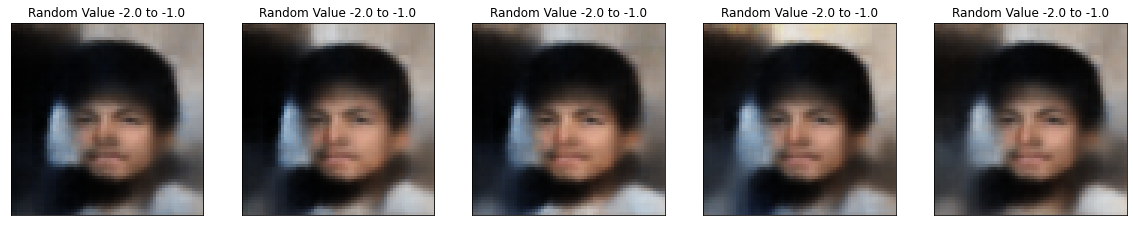

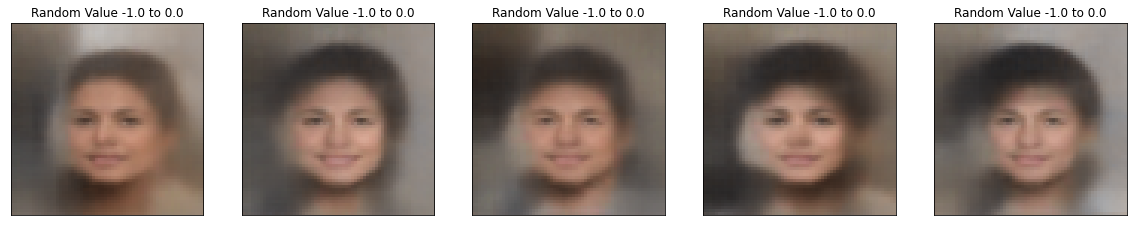

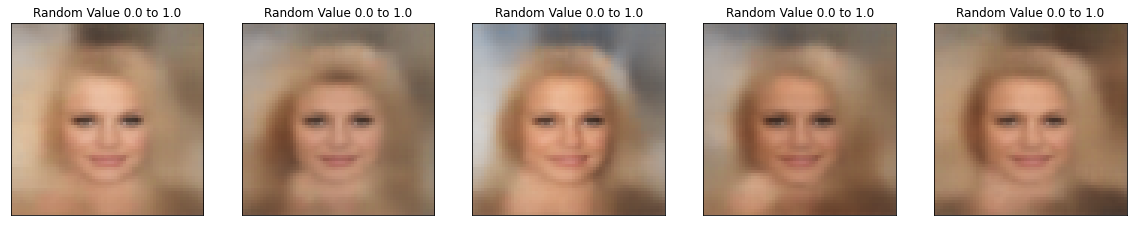

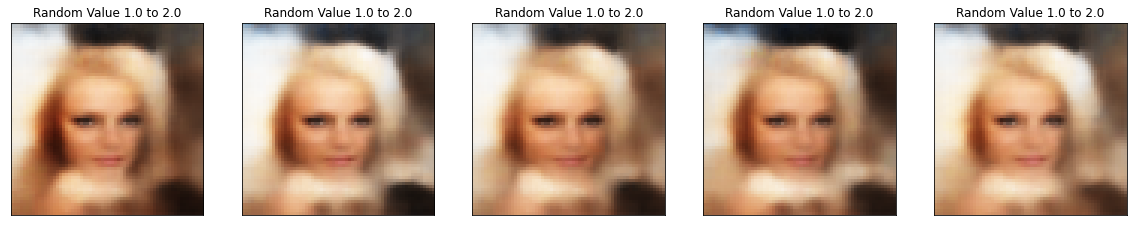

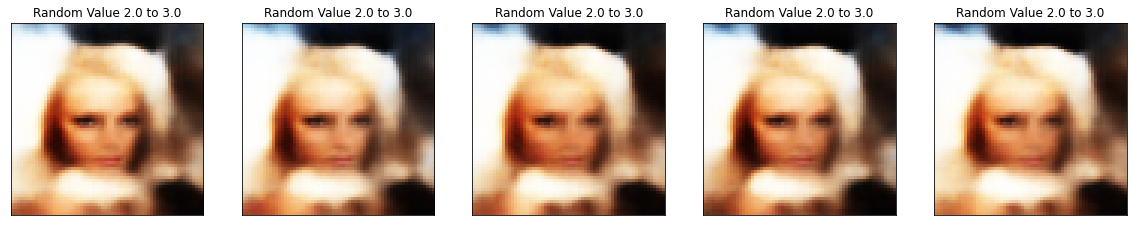

In [ ]:
lst_generate = [[-4.0,-2.0],[-2.0,-1.0],[-1.0,0.0],[0.0,1.0],[1.0,2.0],[2.0,3.0]]

for val in lst_generate:
   plt.figure(figsize=(20,25))
   for gen in range(5):
     z_simple = np.random.uniform(val[0],val[1],[1,1000])
     plt.subplot(150+1+gen).set_title(f"Random Value {val[0]} to {val[1]}")
     gen_img = (decoder.predict(z_simple)[0]*255).astype(np.uint8)
     plt.imshow( gen_img )
     plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
   plt.show()